In [1]:
# Get the data for expeirment
import sklearn
import pandas as pd 
import numpy as np

from sklearn import tree
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import explained_variance_score, mean_squared_error
from scipy.spatial.distance import cdist
from numpy.linalg import pinv
from math import sqrt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import geopy.distance as distance
from sklearn.preprocessing import MinMaxScaler

import Data_utils
import matplotlib.ticker as ticker
from functools import reduce
from collections import Counter

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# training = pd.read_csv('Data/ab_wind_train_data.txt')
# testing = pd.read_csv('Data/ab_wind_test_data.txt')
# All data without null, 2.5m
data = pd.read_csv('Data\processed_ab_wind.csv')

C:\Users\PPL\AppData\Local\Temp\ipykernel_65228\2481163954.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Data\processed_ab_wind.csv')


In [4]:
grouped_by_date_data = data.groupby('date')

In [5]:
np.bincount(grouped_by_date_data.size()).argmax() #32 stations is the max number of stations for most dates

32

In [6]:
size = grouped_by_date_data.size()

Text(0.5, 0, 'Number of stations')

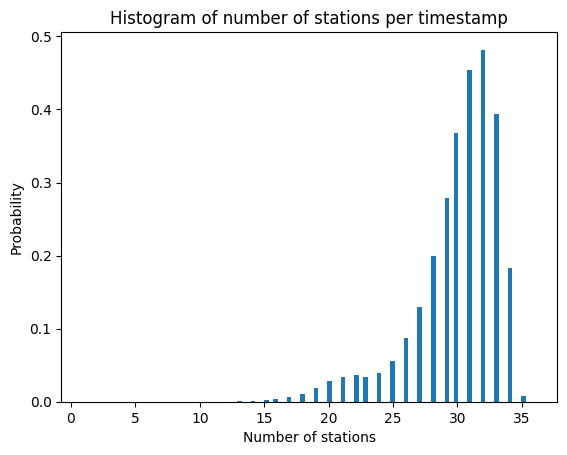

In [7]:
plt.hist(size, bins=100, density=True)
plt.title("Histogram of number of stations per timestamp")
plt.ylabel("Probability")
plt.xlabel("Number of stations")

In [8]:
number_of_stations_in_dates = [31, 32, 33, 34, 35] 
common_stations = []

for number in number_of_stations_in_dates:
    dates_with_major_stations = size.index[size == number]
    filtered_data = data.loc[data['date'].isin(dates_with_major_stations)]
    filtered_data_names = filtered_data.groupby('date')['name'].apply(list)
    filtered_data_names_list = filtered_data_names.values.tolist()
    res = list(reduce(lambda i, j: i & j, (set(x) for x in filtered_data_names_list[0:10])))
    
    common_stations.append(res)


In [9]:
common_station_names = list(reduce(lambda i, j: i & j, (set(x) for x in common_stations)))

In [10]:
dates_with_most_stations = size.index[size >= 31]

In [11]:
dates_with_most_stations

Index(['2014-05-28 14:00', '2014-05-28 16:00', '2014-05-28 17:00',
       '2014-05-29 11:00', '2014-05-29 19:00', '2014-05-30 02:00',
       '2014-05-30 11:00', '2014-05-31 14:00', '2014-05-31 19:00',
       '2014-05-31 20:00',
       ...
       '2023-09-14 11:00', '2023-09-14 12:00', '2023-09-14 13:00',
       '2023-09-14 14:00', '2023-09-14 15:00', '2023-09-14 16:00',
       '2023-09-14 17:00', '2023-09-14 18:00', '2023-09-14 19:00',
       '2023-09-14 20:00'],
      dtype='object', name='date', length=45590)

In [12]:
filtered_data = data.loc[data['date'].isin(dates_with_most_stations)]

In [16]:
filtered_data['name'].unique().shape

(38,)

In [17]:
teacher, student = train_test_split(dates_with_most_stations, test_size = 0.1)

In [18]:
#filtered_train_dates, filtered_test_dates = train_test_split(filtered_test_dates, test_size = 0.3)

In [19]:
filtered_teacher = filtered_data.loc[filtered_data['date'].isin(teacher) & filtered_data['name'].isin(common_station_names)]
filtered_student = filtered_data.loc[filtered_data['date'].isin(student) & filtered_data['name'].isin(common_station_names)]

In [22]:
filtered_student['name'].unique().shape

(25,)

In [40]:
# filtered_test.to_csv('Data\processed_ab_student.csv', sep = ',', index = False)
# filtered_train.to_csv('Data\processed_ab_teacher.csv', sep = ',', index = False)

In [42]:
train_dates, test_dates = train_test_split(teacher, test_size = 0.3)

In [45]:
train_data = filtered_teacher.loc[filtered_teacher['date'].isin(train_dates) & filtered_teacher['name'].isin(common_station_names)]
test_data = filtered_teacher.loc[filtered_teacher['date'].isin(test_dates) & filtered_teacher['name'].isin(common_station_names)]

In [48]:
# train_data.to_csv('Data\processed_ab_teacher_train.txt', sep = ',', index = False)
# test_data.to_csv('Data\processed_ab_teacher_test.txt', sep = ',', index = False)

In [98]:
train_data = pd.read_csv('Data\processed_ab_teacher_train.txt')
test_data = pd.read_csv('Data\processed_ab_teacher_test.txt')

C:\Users\PPL\AppData\Local\Temp\ipykernel_65228\2417379012.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data_temp = pd.read_csv('Data\processed_ab_teacher_train.txt')


In [100]:
train_data_temp['date'].unique().shape

(28721,)

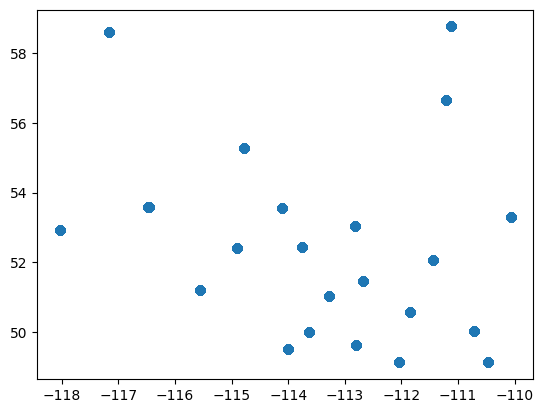

In [86]:
plt.scatter(x=train_data['longitude'], y=train_data['latitude'])
plt.show()

In [88]:
train_data_dates = train_data['date'].unique()

In [90]:
train_data_dates.shape

(28721,)

In [91]:
train_data_dates,_ = train_test_split(train_data_dates, test_size = 0.4)

In [92]:
train_data = train_data.loc[train_data['date'].isin(train_data_dates)]

In [102]:
train_data['date'].unique().shape

(17232,)

In [103]:
# Source: From the TSmodel
def preprocess_data(train, validation):
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train)
    validation_data = scaler.transform(validation)
    
    return train_data, validation_data

In [104]:
def fcm_rule_model(train_x, train_y, validation_x, validation_y):
    # Fcm hyperparameters
    FCM_Nc = 100
    FCM_m = 2
    tol = 1e-5
    max_iter = 200
        
    N = train_x.shape[0]
    U = np.random.rand(N, FCM_Nc)
    U = U / np.sum(U, axis=1, keepdims=True)
    qs = []

    # Fuzzy C-Means 聚类
    for _ in range(max_iter):
        U_old = U.copy()
        mf = U ** FCM_m
        cen = np.dot(mf.T, train_x) / np.sum(mf, axis=0, keepdims=True).T
        dists = cdist(train_x, cen)
        tmp = np.power(dists, -2 / (FCM_m - 1))
        U = tmp / np.sum(tmp, axis=1, keepdims=True)

        q = np.sum((U ** FCM_m) * (dists ** 2))
        qs.append(q)

        # 检查是否收敛
        if np.linalg.norm(U - U_old) < tol:
            break
    # 模型训练
    z = np.hstack((np.ones((N, 1)), train_x))
    H = np.zeros((N, FCM_Nc * (train_x.shape[1] + 1)))

    # 生成模糊规则矩阵 H
    for j in range(FCM_Nc):
        Uj = np.tile(U[:, j], (train_x.shape[1] + 1, 1)).T
        H[:, (j * (train_x.shape[1] + 1)):((j + 1) * (train_x.shape[1] + 1))] = Uj * z

    # 计算权重 W
    W = pinv(np.dot(H.T, H)).dot(H.T).dot(train_y)

        
    # 在训练集上进行预测
    y_hat_train = np.dot(H, W)
    mse_train = mean_squared_error(train_y, y_hat_train)
    rmse_train = sqrt(mean_squared_error(train_y, y_hat_train))
    print("FCM traning RMSE:", rmse_train)
    
    # validation
    N_validation = validation_x.shape[0]
    z_validation = np.hstack((np.ones((N_validation, 1)), validation_x))
    H_validation = np.zeros((N_validation, FCM_Nc * (validation_x.shape[1] + 1)))
    dists_validation = cdist(validation_x, cen)
    tmp_validation = np.power(dists_validation, -2 / (FCM_m - 1))
    U_validation = tmp_validation / np.sum(tmp_validation, axis=1, keepdims=True)

    # 生成模糊规则矩阵 H_test
    for j in range(FCM_Nc):
        Uj_validation = np.tile(U_validation[:, j], (validation_x.shape[1] + 1, 1)).T
        H_validation[:, (j * (validation_x.shape[1] + 1)):((j + 1) * (validation_x.shape[1] + 1))] = Uj_validation * z_validation

    # validation set
    y_hat_validation = np.dot(H_validation, W)
    mse_validation = mean_squared_error(validation_y, y_hat_validation)
    rmse_validation = sqrt(mse_validation)
    print("FCM val RMSE:", rmse_validation)
    

    # 模型测试
#     N_test = test_x.shape[0]
#     z_test = np.hstack((np.ones((N_test, 1)), test_x))
#     H_test = np.zeros((N_test, FCM_Nc * (test_x.shape[1] + 1)))
#     dists_test = cdist(test_x, cen)
#     tmp_test = np.power(dists_test, -2 / (FCM_m - 1))
#     U_test = tmp_test / np.sum(tmp_test, axis=1, keepdims=True)

#     # 生成模糊规则矩阵 H_test
#     for j in range(FCM_Nc):
#         Uj_test = np.tile(U_test[:, j], (test_x.shape[1] + 1, 1)).T
#         H_test[:, (j * (test_x.shape[1] + 1)):((j + 1) * (test_x.shape[1] + 1))] = Uj_test * z_test

#     # 在测试集上进行预测
#     y_hat_test = np.dot(H_test, W)
#     mse_test = mean_squared_error(test_y, y_hat_test)
#     rmse_test = sqrt(mean_squared_error(test_y, y_hat_test))
#     print("test MSE:", mse_test)
#     print("test RMSE:", rmse_test)
#     test_results.append({'fcm_test':rmse_test})
    
        
#     print('r2 score')
#     print(r2_score(test_y, y_hat_test))


    # 绘制拟合曲线
#     plt.figure()
#     plt.subplot(1, 2, 1)
#     plt.plot([min(train_y),max(train_y)], [min(train_y),max(train_y)], 'k--')
#     plt.plot(train_y, y_hat_train, 'ro', alpha=.2)
#     plt.title('Training')
#     plt.legend()

#     plt.subplot(1, 2, 2)
#     plt.plot([min(validation_y),max(validation_y)], [min(validation_y),max(validation_y)], 'k--')
#     plt.plot(validation_y, y_hat_validation, 'ro', alpha=.2)
#     plt.title('Testing')
#     plt.legend()
#     plt.show()
    plt.figure(figsize=(8,8))    
    plt.plot([min(validation_y),max(validation_y)], [min(validation_y),max(validation_y)], 'k--')
    plt.plot(validation_y, y_hat_validation, 'ro', alpha=.2)
    plt.title('TS model prediction vs true value for testing data')
    #plt.legend()
    
    plt.figure(figsize=(8,8))
    plt.plot(qs)
    #plt.show()

    return rmse_train, rmse_validation


In [105]:
def linear_model(train_x, train_y, validation_x, validation_y):
    reg = LinearRegression().fit(train_x, train_y)
        
    train_pred = reg.predict(train_x)
    
    validation_pred = reg.predict(validation_x)
    
    print("linear train")
    print(mean_squared_error(train_y, train_pred, squared = False))
    
    print("linear_validation")
    print(mean_squared_error(validation_y, validation_pred, squared = False))
    
    return mean_squared_error(train_y, train_pred, squared = False), mean_squared_error(validation_y, validation_pred, squared = False)

In [106]:
def build_neural_network_model():
    model = models.Sequential()
    
    model.add(layers.Dense(30, activation=tf.keras.activations.tanh))    
    model.add(layers.Dense(1))    
    
    return model

In [107]:
def neural_network_model(train_x, train_y, validation_x, validation_y):
    neural_network_model = build_neural_network_model()
    
    neural_network_model.compile(
        optimizer='adam',
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    
    history = neural_network_model.fit(
        train_x, 
        train_y, 
        epochs=number_of_epochs, 
        validation_data=(validation_x, validation_y)
    )
    
    return history, np.mean(np.array(history.history['root_mean_squared_error'])), np.mean(np.array(history.history['val_root_mean_squared_error'])), neural_network_model

In [108]:
# Filter and process the data suitable for the training/testing
def generate_exp_data(raw_data, number_of_stations, max_threshold_distance, min_threshold_distance):
    # First fitler the data based on the settings
    x = []
    y = []

    for station in raw_data['name'].unique():
        features, target = Data_utils.generate_data(
            raw_data, 
            station, 
            number_of_stations, 
            max_threshold_distance, 
            min_threshold_distance
        )

        if (len(features)!=0) & (len(target)!=0):
            np_features = np.array(features)
            np_target = np.array(target)

            x.append(np_features)
            y.append(np_target)
    
    return x, y

In [109]:
# hyperparameters for the expeirment
number_of_neighbour_stations = [1,2,3,4,5,6, 7, 8, 9, 10]
number_of_epochs = 50

# Expeirment related parameters
number_of_folds = 5
# General hyperparameter
max_threshold_distance = 100000 #km
min_threshold_distance = 0 #km

# Results containers
training_results = []
validation_results = []
nn_histories = []

# Determine the optimal value for the given hyperparameter
def do_experiment(hyper_parameter_to_test_values, training_data):
    kf = KFold(n_splits=number_of_folds, shuffle=True)
    j = 1
    
    for hyperparameter_value in hyper_parameter_to_test_values:
        # First fitler the data based on the settings
        train_x, train_y = generate_exp_data(training_data, hyperparameter_value, max_threshold_distance, min_threshold_distance)
        
        # After all stations are filtered, flatten the data into a huge list        
        flatten_x = np.array([data for sublist in train_x for data in sublist])
        flatten_y = np.array([data for sublist in train_y for data in sublist])
        
        temp_x = pd.DataFrame(flatten_x)
        temp_x.to_csv(f"Data\exp\{j}x.csv")
        temp_y = pd.DataFrame(flatten_y)
        temp_y.to_csv(f"Data\exp\{j}y.csv")
        
        # After all data are ready, do a 10 fold cross validation
        training_results_fold = []
        validation_results_fold = []
        test_results_fold = []
        nn_history_fold = []
        
        for i, (train_index, val_index) in enumerate(kf.split(flatten_x)):
            split_train_x = flatten_x[train_index]
            split_train_y = flatten_y[train_index]

            split_val_x = flatten_x[val_index]
            split_val_y = flatten_y[val_index]
            # Normalize the input
            split_train_x, split_val_x = preprocess_data(split_train_x, split_val_x)            
            # Linear model
            li_train_rmse, li_val_rmse = linear_model(split_train_x, split_train_y, split_val_x , split_val_y)
            training_results_fold.append({'linear_train' : li_train_rmse})
            validation_results_fold.append({'linear_val' : li_val_rmse})
            
            # FCM model
            fcm_train_rmse, fcm_val_rmse = fcm_rule_model(split_train_x, split_train_y, split_val_x , split_val_y)
            training_results_fold.append({'fcm_train' : fcm_train_rmse})
            validation_results_fold.append({'fcm_val' : fcm_val_rmse})
            
            # NN
            nn_history, nn_train_rmse, nn_val_rmse, _ = neural_network_model(split_train_x, split_train_y, split_val_x , split_val_y)
            nn_history_fold.append(nn_history.history)
            training_results_fold.append({'nn_train' : nn_train_rmse})
            validation_results_fold.append({'nn_val' : nn_val_rmse})
        
        #After all folds are done, update the result containers
        training_results.append(training_results_fold)
        validation_results.append(validation_results_fold)
        nn_histories.append(nn_history_fold)
        j = j+1
        
        

In [ ]:
do_experiment(number_of_neighbour_stations, train_data)

linear train
7.591591226812526
linear_validation
7.6147214290141365
FCM traning RMSE: 7.485164959003661
FCM val RMSE: 7.511998001235346
Epoch 1/50
9518/9518 [==============================] - 29s 3ms/step - loss: 64.8326 - root_mean_squared_error: 8.0519 - val_loss: 56.2346 - val_root_mean_squared_error: 7.4990
Epoch 2/50
9518/9518 [==============================] - 30s 3ms/step - loss: 54.9040 - root_mean_squared_error: 7.4097 - val_loss: 54.6794 - val_root_mean_squared_error: 7.3946
Epoch 3/50
9518/9518 [==============================] - 28s 3ms/step - loss: 53.6065 - root_mean_squared_error: 7.3216 - val_loss: 53.7124 - val_root_mean_squared_error: 7.3289
Epoch 4/50
9518/9518 [==============================] - 29s 3ms/step - loss: 52.6960 - root_mean_squared_error: 7.2592 - val_loss: 52.7065 - val_root_mean_squared_error: 7.2599
Epoch 5/50
9518/9518 [==============================] - 31s 3ms/step - loss: 52.0319 - root_mean_squared_error: 7.2133 - val_loss: 52.1279 - val_root_mean_s

9518/9518 [==============================] - 31s 3ms/step - loss: 44.2423 - root_mean_squared_error: 6.6515 - val_loss: 44.9341 - val_root_mean_squared_error: 6.7033
Epoch 42/50
9518/9518 [==============================] - 32s 3ms/step - loss: 44.2291 - root_mean_squared_error: 6.6505 - val_loss: 44.8333 - val_root_mean_squared_error: 6.6958
Epoch 43/50
9518/9518 [==============================] - 32s 3ms/step - loss: 44.2021 - root_mean_squared_error: 6.6485 - val_loss: 44.8572 - val_root_mean_squared_error: 6.6976
Epoch 44/50
9518/9518 [==============================] - 31s 3ms/step - loss: 44.1753 - root_mean_squared_error: 6.6464 - val_loss: 44.8178 - val_root_mean_squared_error: 6.6946
Epoch 45/50
9518/9518 [==============================] - 31s 3ms/step - loss: 44.1460 - root_mean_squared_error: 6.6442 - val_loss: 44.7913 - val_root_mean_squared_error: 6.6926
Epoch 46/50
9518/9518 [==============================] - 32s 3ms/step - loss: 44.1127 - root_mean_squared_error: 6.6417 - 

9518/9518 [==============================] - 32s 3ms/step - loss: 44.6782 - root_mean_squared_error: 6.6842 - val_loss: 44.4398 - val_root_mean_squared_error: 6.6663
Epoch 32/50
9518/9518 [==============================] - 31s 3ms/step - loss: 44.6167 - root_mean_squared_error: 6.6796 - val_loss: 44.4146 - val_root_mean_squared_error: 6.6644
Epoch 33/50
9518/9518 [==============================] - 32s 3ms/step - loss: 44.5688 - root_mean_squared_error: 6.6760 - val_loss: 44.4003 - val_root_mean_squared_error: 6.6634
Epoch 34/50
9518/9518 [==============================] - 32s 3ms/step - loss: 44.5127 - root_mean_squared_error: 6.6718 - val_loss: 44.3106 - val_root_mean_squared_error: 6.6566
Epoch 35/50
9518/9518 [==============================] - 31s 3ms/step - loss: 44.4681 - root_mean_squared_error: 6.6684 - val_loss: 44.2139 - val_root_mean_squared_error: 6.6493
Epoch 36/50
9518/9518 [==============================] - 32s 3ms/step - loss: 44.4227 - root_mean_squared_error: 6.6650 - 

9052/9052 [==============================] - 30s 3ms/step - loss: 39.1479 - root_mean_squared_error: 6.2568 - val_loss: 39.1383 - val_root_mean_squared_error: 6.2561
Epoch 22/50
9052/9052 [==============================] - 30s 3ms/step - loss: 39.1013 - root_mean_squared_error: 6.2531 - val_loss: 39.0198 - val_root_mean_squared_error: 6.2466
Epoch 23/50
9052/9052 [==============================] - 29s 3ms/step - loss: 39.0637 - root_mean_squared_error: 6.2501 - val_loss: 38.8823 - val_root_mean_squared_error: 6.2356
Epoch 24/50
9052/9052 [==============================] - 30s 3ms/step - loss: 39.0188 - root_mean_squared_error: 6.2465 - val_loss: 39.0370 - val_root_mean_squared_error: 6.2480
Epoch 25/50
9052/9052 [==============================] - 30s 3ms/step - loss: 38.9807 - root_mean_squared_error: 6.2435 - val_loss: 39.0023 - val_root_mean_squared_error: 6.2452
Epoch 26/50
9052/9052 [==============================] - 30s 3ms/step - loss: 38.9521 - root_mean_squared_error: 6.2412 - 

9052/9052 [==============================] - 31s 3ms/step - loss: 40.0048 - root_mean_squared_error: 6.3249 - val_loss: 39.9819 - val_root_mean_squared_error: 6.3231
Epoch 12/50
9052/9052 [==============================] - 30s 3ms/step - loss: 39.8735 - root_mean_squared_error: 6.3146 - val_loss: 39.8516 - val_root_mean_squared_error: 6.3128
Epoch 13/50
9052/9052 [==============================] - 29s 3ms/step - loss: 39.7344 - root_mean_squared_error: 6.3035 - val_loss: 39.9138 - val_root_mean_squared_error: 6.3177
Epoch 14/50
9052/9052 [==============================] - 29s 3ms/step - loss: 39.5862 - root_mean_squared_error: 6.2918 - val_loss: 39.7339 - val_root_mean_squared_error: 6.3035
Epoch 15/50
9052/9052 [==============================] - 30s 3ms/step - loss: 39.4870 - root_mean_squared_error: 6.2839 - val_loss: 39.5392 - val_root_mean_squared_error: 6.2880
Epoch 16/50
9052/9052 [==============================] - 30s 3ms/step - loss: 39.3676 - root_mean_squared_error: 6.2744 - 

9052/9052 [==============================] - 31s 3ms/step - loss: 59.6862 - root_mean_squared_error: 7.7257 - val_loss: 47.7938 - val_root_mean_squared_error: 6.9133
Epoch 2/50
9052/9052 [==============================] - 30s 3ms/step - loss: 45.9106 - root_mean_squared_error: 6.7757 - val_loss: 44.7712 - val_root_mean_squared_error: 6.6911
Epoch 3/50
9052/9052 [==============================] - 30s 3ms/step - loss: 43.6514 - root_mean_squared_error: 6.6069 - val_loss: 42.9244 - val_root_mean_squared_error: 6.5517
Epoch 4/50
9052/9052 [==============================] - 30s 3ms/step - loss: 42.4873 - root_mean_squared_error: 6.5182 - val_loss: 42.1780 - val_root_mean_squared_error: 6.4945
Epoch 5/50
9052/9052 [==============================] - 31s 3ms/step - loss: 41.7748 - root_mean_squared_error: 6.4633 - val_loss: 41.5024 - val_root_mean_squared_error: 6.4422
Epoch 6/50
9052/9052 [==============================] - 30s 3ms/step - loss: 41.2112 - root_mean_squared_error: 6.4196 - val_l

C:\Users\PPL\AppData\Local\Temp\ipykernel_65228\282031044.py:107: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8,8))


Epoch 1/50
8695/8695 [==============================] - 29s 3ms/step - loss: 55.1055 - root_mean_squared_error: 7.4233 - val_loss: 41.5870 - val_root_mean_squared_error: 6.4488
Epoch 2/50
8695/8695 [==============================] - 29s 3ms/step - loss: 40.9425 - root_mean_squared_error: 6.3986 - val_loss: 39.8890 - val_root_mean_squared_error: 6.3158
Epoch 3/50
8695/8695 [==============================] - 29s 3ms/step - loss: 39.6651 - root_mean_squared_error: 6.2980 - val_loss: 38.9228 - val_root_mean_squared_error: 6.2388
Epoch 4/50
8695/8695 [==============================] - 30s 3ms/step - loss: 38.9001 - root_mean_squared_error: 6.2370 - val_loss: 38.5816 - val_root_mean_squared_error: 6.2114
Epoch 5/50
8695/8695 [==============================] - 29s 3ms/step - loss: 38.3851 - root_mean_squared_error: 6.1956 - val_loss: 37.6779 - val_root_mean_squared_error: 6.1382
Epoch 6/50
8695/8695 [==============================] - 29s 3ms/step - loss: 37.9608 - root_mean_squared_error: 6.1

8695/8695 [==============================] - 28s 3ms/step - loss: 35.4157 - root_mean_squared_error: 5.9511 - val_loss: 36.1406 - val_root_mean_squared_error: 6.0117
Epoch 43/50
8695/8695 [==============================] - 28s 3ms/step - loss: 35.3918 - root_mean_squared_error: 5.9491 - val_loss: 36.0988 - val_root_mean_squared_error: 6.0082
Epoch 44/50
8695/8695 [==============================] - 28s 3ms/step - loss: 35.3806 - root_mean_squared_error: 5.9482 - val_loss: 36.1137 - val_root_mean_squared_error: 6.0095
Epoch 45/50
8695/8695 [==============================] - 28s 3ms/step - loss: 35.3788 - root_mean_squared_error: 5.9480 - val_loss: 36.0824 - val_root_mean_squared_error: 6.0069
Epoch 46/50
8695/8695 [==============================] - 28s 3ms/step - loss: 35.3549 - root_mean_squared_error: 5.9460 - val_loss: 36.1234 - val_root_mean_squared_error: 6.0103
Epoch 47/50
8695/8695 [==============================] - 28s 3ms/step - loss: 35.3556 - root_mean_squared_error: 5.9461 - 

8695/8695 [==============================] - 30s 3ms/step - loss: 35.7944 - root_mean_squared_error: 5.9828 - val_loss: 35.8928 - val_root_mean_squared_error: 5.9911
Epoch 33/50
8695/8695 [==============================] - 30s 3ms/step - loss: 35.7648 - root_mean_squared_error: 5.9804 - val_loss: 35.8084 - val_root_mean_squared_error: 5.9840
Epoch 34/50
8695/8695 [==============================] - 29s 3ms/step - loss: 35.7551 - root_mean_squared_error: 5.9796 - val_loss: 35.7804 - val_root_mean_squared_error: 5.9817
Epoch 35/50
8695/8695 [==============================] - 28s 3ms/step - loss: 35.7196 - root_mean_squared_error: 5.9766 - val_loss: 35.9877 - val_root_mean_squared_error: 5.9990
Epoch 36/50
8695/8695 [==============================] - 29s 3ms/step - loss: 35.7026 - root_mean_squared_error: 5.9752 - val_loss: 35.7562 - val_root_mean_squared_error: 5.9796
Epoch 37/50
8695/8695 [==============================] - 28s 3ms/step - loss: 35.6882 - root_mean_squared_error: 5.9740 - 

In [7]:
plot_data = pd.read_csv('Data/exp/1x.csv')
plot_data_y = pd.read_csv('Data/exp/1y.csv')

In [12]:
plt.rcParams.update({'font.size': 16})

Text(0, 0.5, 'Wind speed')

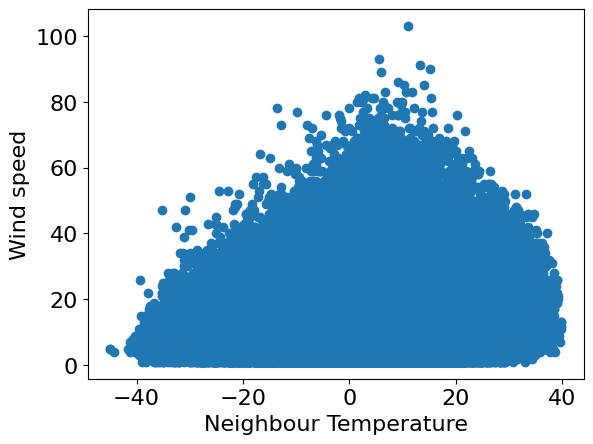

In [21]:
plt.scatter(plot_data['2'], plot_data_y['0'])
plt.xlabel('Neighbour Temperature')
plt.ylabel('Wind speed')

In [6]:
plot_data

,Unnamed: 0,0,1,2,3,4,5,6
0,0,52.45,-113.76,8.6,1.6,9.0,14.0,92.122831
1,1,52.45,-113.76,8.4,0.8,9.0,13.0,92.122831
2,2,52.45,-113.76,6.0,0.0,17.0,5.0,92.122831
3,3,52.45,-113.76,19.2,0.0,9.0,21.0,92.122831
4,4,52.45,-113.76,19.1,0.0,30.0,25.0,92.122831
...,...,...,...,...,...,...,...,...
380679,380679,58.77,-111.12,14.2,0.0,31.0,18.0,350.495028
380680,380680,58.77,-111.12,17.2,0.0,30.0,15.0,350.495028
380681,380681,58.77,-111.12,17.9,0.0,32.0,13.0,350.495028
380682,380682,58.77,-111.12,17.1,0.0,34.0,9.0,350.495028


ValueError: x and y must have same first dimension, but have shapes (6,) and (1,)

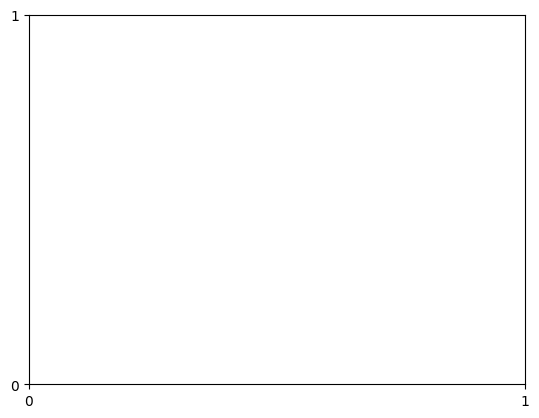

In [81]:
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
x_axis = number_of_neighbour_stations
#x_axis = [1,2,3,4,5,6,7,8,9,10]
for exp in training_results:
     li_train_plot.append(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]))
     fcm_train_plot.append(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]))
#     nn_train_plot.append(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]))
# exp = validation_results[1]
# li_train_plot = [d['linear_val'] for d in exp if 'linear_val' in d]
# fcm_train_plot = [d['fcm_val'] for d in exp if 'fcm_val' in d]
#nn_train_plot = [d['nn_val'] for d in exp if 'nn_val' in d]

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
    
plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='fcm', c='blue')
#plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
plt.legend(loc="upper left")
#plt.ylim(5)
plt.xlabel('Fold')
plt.ylabel('RMSE wind speed')
plt.title('RMSE wind speed vs fold on validation data')

print(f"{np.round(np.mean(fcm_train_plot), 4)}±{np.round(np.std(fcm_train_plot),4)}")

6.6986±0.0825


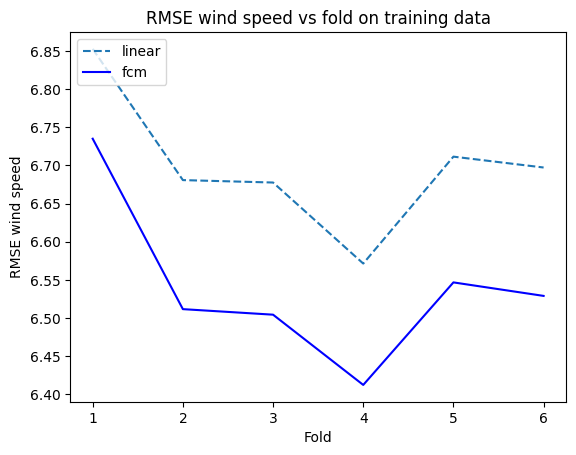

In [30]:
li_train_plot = []
fcm_train_plot = []
nn_train_plot = []
x_axis = number_of_neighbour_stations
#x_axis = [1,2,3,4,5,6,7,8,9,10]
for exp in training_results:
     li_train_plot.append(np.mean([d['linear_train'] for d in exp if 'linear_train' in d]))
     fcm_train_plot.append(np.mean([d['fcm_train'] for d in exp if 'fcm_train' in d]))
#     nn_train_plot.append(np.mean([d['nn_train'] for d in exp if 'nn_train' in d]))
# exp = training_results[0]
# li_train_plot = [d['linear_train'] for d in exp if 'linear_train' in d]
# fcm_train_plot = [d['fcm_train'] for d in exp if 'fcm_train' in d]
# nn_train_plot = [d['nn_train'] for d in exp if 'nn_train' in d]

fig, ax = plt.subplots()
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_locator(ticker.MaxNLocator(integer=True))
    
plt.plot(x_axis, li_train_plot, '--', label='linear')
plt.plot(x_axis, fcm_train_plot, label='fcm', c='blue')
#plt.plot(x_axis, nn_train_plot, label='neural network', c='pink')
plt.legend(loc="upper left")
#plt.ylim(5)
plt.xlabel('Fold')
plt.ylabel('RMSE wind speed')
plt.title('RMSE wind speed vs fold on training data')


print(f"{np.round(np.mean(li_train_plot), 4)}±{np.round(np.std(li_train_plot),4)}")